# Analysis II - Spherical+Cylindrical

In [3]:
# Initialize these:
typeImg = "top" # photo/ cartoon/ all"
numImg = "50" # 5 or 50
sz = 100
filepath = 'dataTop50.xlsx'


# For spherical
# a=0; b= 30
# # For cylindrical
# a = 30; b =180
# # For categorical
# a = 180; b= 186

strtInd = [0, 2900, 5800, 8700, 11600, 14500, 17400, 20300, 23200, 26100, 29000, 31900, 34800]

In [4]:
 # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os
import pandas as pd
import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
colNames = ["col_"+str(i) for i in range(58)] 
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']

# Read data
# Get the color ratings data -From file data_clean.csv
data = pd.read_csv("data_clean.csv",names = colNames)

# Get the LAB coordinates of colors from file LabOrig.csv
#colorData = pd.read_csv("LabOrig.csv",header=None)
colorData = pd.read_csv("Lab.csv",header=None)
colorDataRGB = pd.read_csv("RGB.csv",header=None)
path = "E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads"
sz = 100

In [6]:
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(34800, 187)

# Spherical + Cylindrical

In [46]:
X = np.copy(Q[:,:180])
y = np.copy(Q[:,-1])

In [47]:
xNew = np.column_stack([X,y])
print(xNew.shape)
xTemp = np.copy(xNew)

(34800, 181)



Leaving out fruit group :  mango
The top 3 features are:
Sparse Coefficients: 
   (0, 0)	0.14686590007317038
  (0, 55)	0.21375286721223385
  (0, 179)	0.057423344079769664
  (0, 180)	0.08847676828186023
[26, 24, 22, 17, 14, 12, 10, 9, 8, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1]

Leaving out fruit group :  watermelon
The top 3 features are:
Sparse Coefficients: 
   (0, 0)	0.13910700896868788
  (0, 55)	0.22923285110460323
  (0, 179)	0.034568117073880314
  (0, 180)	0.11448634687934287
[30, 27, 21, 18, 16, 12, 12, 10, 10, 7, 6, 6, 6, 6, 5, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1]

Leaving out fruit group :  honeydew
The top 3 features are:
Sparse Coefficients: 
   (0, 0)	0.14463193765496768
  (0, 55)	0.23130682982179523
  (0, 179)	0.09617095620462246
  (0, 180)	0.05585174606800457
[33, 27, 23, 18, 16, 14, 12, 11, 9, 7, 5, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1]

Leaving out fruit group :  cantaloupe
The top 3 features are:
Sparse Coefficients: 
  

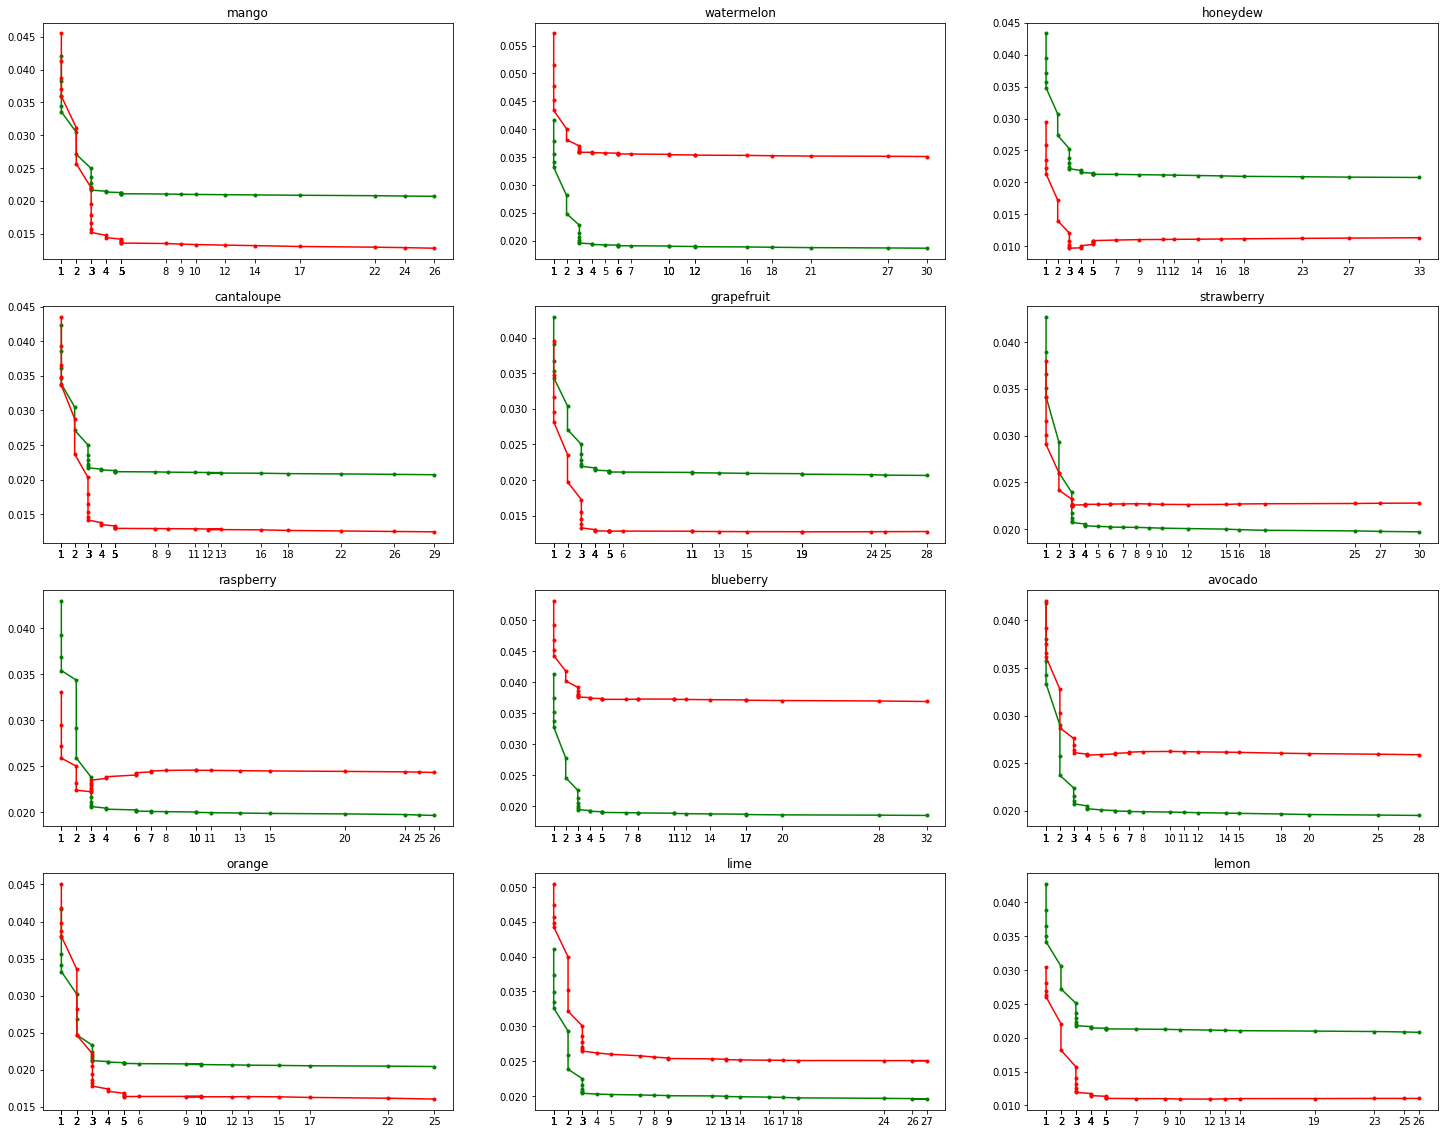

In [48]:
alpha = np.logspace(-4,-1,30, endpoint=True)
# plt.plot(alpha,'g.-')
# plt.show()
#print(alpha)
errorTrainAlpha = np.zeros((12,len(alpha)))  # Saves error values across different alpha values for all fruits
errorTestAlpha = np.zeros((12,len(alpha)))  # Saves error values across different alpha values for all fruits


ftTrainDict = {}
ftTestDict = {}
# Linear Regression using Cross Validation
# Leave one out cross validation -- strtInd holds the starting indices of set of fruit data 
plt.close('all')

fig1,ax1 = plt.subplots(4,3,figsize=(25,20))
#fig2,ax2 = plt.subplots(4,3,figsize=(25,20))
p = 0
q = 0
for i in range(len(strtInd)-1):
    numFt = []
    trainErrFt = []
    testErrFt = []
    trDict = {}
    teDict = {}
    
    # Leave one entire fruit group
    testFruit =  allConcepts[i]
    print("\nLeaving out fruit group : ",allConcepts[i])
    testTemp = np.copy(xTemp[strtInd[i]:strtInd[i+1],:]) # Get all rows from the LOO group
    trainTemp = np.delete(xTemp,range(strtInd[i],strtInd[i+1]),0)
    
    #trainTemp = np.copy(xTemp)
    #np.random.shuffle(trainTemp)
    row = len(trainTemp)
    
    #Training set
    X_train = np.column_stack([np.ones((row,1)), trainTemp[:,:-1]]) # add offset
    y_train = np.copy(trainTemp[:,-1])
    # Test set (hold out set)
    row2 = len(testTemp)
    X_test  = np.column_stack([np.ones((row2,1)), testTemp[:,:-1]]) #xTemp[row:tot,0:3]#
    y_test  = np.copy(testTemp[:,-1])
    #print(X_train.shape, y_train.shape,X_test.shape, y_test.shape )
    # Before Lasso --> do a LinearRegression to compute error using all 58
    ct = 0
    for m,a in enumerate(alpha):
        #print("\n\n---------------- For alpha value : ",a," -------------")
        # Create linear regression object
        #regr = linear_model.LinearRegression(fit_intercept=False)
        regr = linear_model.Lasso(alpha = a,fit_intercept=False,copy_X = True, max_iter=3000)
        #print(regr)
        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        ytrain_pred = regr.predict(X_train)
        
        ft = np.count_nonzero(regr.coef_)
        #print("Non zero features: ",ft)
        numFt.append(ft)
        if ct ==0 and ft == 4:
            print("The top 3 features are:")
            print("Sparse Coefficients: \n",regr.sparse_coef_)
            ct = 1
#         print("Score is : %.2f" % regr.score(X_test, y_test))
#         # The coefficients
#         print('Coefficients: ', regr.coef_)
        #print("Sparse Coefficients: \n",regr.sparse_coef_)
#         #print('Intercept: \n', regr.intercept_)
#         # The mean squared error
#         print("\nMean squared error: %.4f"
#               % mean_squared_error(y_test, y_pred))
#         # Explained variance score: 1 is perfect prediction
#         print('Variance score: %.2f' % r2_score(y_test, y_pred))
        
        trainErr = mean_squared_error(y_train, ytrain_pred)
        testErr  =  mean_squared_error(y_test, y_pred)
        # Save the avg error vs alpha
        errorTrainAlpha[i,m] = trainErr
        errorTestAlpha[i,m] = testErr
        
        trDict[ft] = trainErr
        teDict[ft] = testErr
        #print(trainErr, testErr)
        
        ## local error wrt the alpha
        trainErrFt.append(trainErr)
        testErrFt.append(testErr)
        ############## For test purposes - Average prediction over all Images of LOO group ############
        totalTestImages = y_pred.size/58  #58N rows -> every image has 58 rows of data
        avg_pred = [np.sum([y_pred[p] for p in range(q,y_pred.size,58)])/totalTestImages for q in range(58)]
    print(numFt)   
    for key in sorted(trDict.keys()):
        if key in ftTrainDict:
            ftTrainDict[key].append(trDict[key])
            ftTestDict[key].append(teDict[key])
        else:
            ftTrainDict[key] = [trDict[key]]
            ftTestDict[key] = [teDict[key]]
    ax1[p,q].plot(numFt,trainErrFt,'g.-',numFt, testErrFt,'r.-')
    ax1[p,q].set_title(testFruit)
    ax1[p,q].set_xticks(numFt)
    ax1[p,q].set_label(['Training','Test'])
    
    
    q += 1
    if q == 3:
        p += 1
        q = 0
plt.show()


### Feature #0: offset
### Feature #55: 20% with L=R=40 and theta = 40
### Feature #79: 40% with L=R=40 and theta = 30
### Feature #180: segmented area with L=R=40 with theta = 40

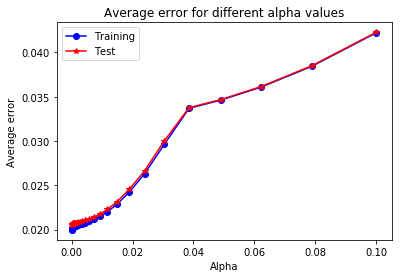

In [53]:
plt.close('all')
plt.plot(alpha,np.mean(errorTrainAlpha,axis=0),'b-o',alpha,np.mean(errorTestAlpha,axis=0),'r-*')
plt.xlabel('Alpha')
plt.ylabel('Average error')
plt.title('Average error for different alpha values')
plt.legend(['Training','Test'])
plt.show()

32


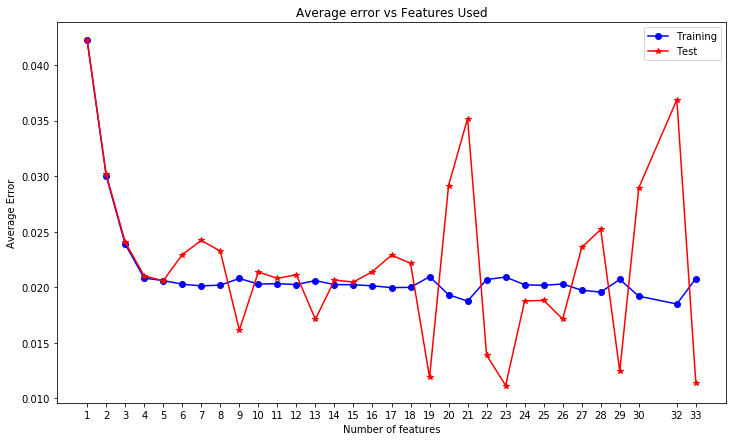

In [54]:
print(len(ftTrainDict.keys()))
import statistics

numbersTrain = [] #[np.mean(ftTrainDict[key]) for key in ftTrainDict]
numbersTest = [] # [np.mean(ftTestDict[key]) for key in ftTestDict]

ftList = sorted(ftTrainDict.keys())
# print(ftTrainDict.keys())
# print([np.mean(ftTrainDict[k]) for k in ftTrainDict])
# print(ftList)
# print([np.mean(ftTrainDict[k]) for k in ftList])
for key in ftList:
    numbersTrain.append(np.mean(ftTrainDict[key]))
    numbersTest.append(np.mean(ftTestDict[key]))
fig = plt.figure(figsize=(12,7))
plt.plot(ftList,numbersTrain,'b-o',ftList, numbersTest, 'r-*')
plt.xlabel("Number of features")
plt.ylabel("Average Error")
plt.title("Average error vs Features Used")
plt.xticks([i for i in ftList])
plt.legend(['Training','Test'])
plt.show()